# Assignment 2: Training the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ stem from a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the [Python3 generator](https://docs.python.org/3/glossary.html#term-generator) pattern and produce data in the way described above. The input sequences should have the shape `(T, 1)` and the target values should have the shape `(1,)`.

In [17]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

class FullyRecurrentNetwork(object):
    def __init__(self, D, I, K):
        self.W = np.random.uniform(-0.01, 0.01, (I, D))
        self.R = np.random.uniform(-0.01, 0.01, (I, I))
        self.V = np.random.uniform(-0.01, 0.01, (K, I))
    
    def forward(self, x, y):
        # helper function for numerically stable loss
        def f(z):
            return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)
        
        # infer dims
        T, D = x.shape
        K, I = self.V.shape

        # init result arrays
        self.x = x
        self.y = y
        self.a = np.zeros((T, I))

        # iterate forward in time 
        # trick: access model.a[-1] in first iteration
        for t in range(T):
            self.a[t] = np.tanh(self.W @ x[t] + self.R @ self.a[t-1])
            
        self.z = model.V @ self.a[t]
        return y * f(-self.z) + (1-y) * f(self.z)

T, D, I, K = 10, 3, 5, 1
model = FullyRecurrentNetwork(D, I, K)
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

def generate_data(T):
    rng = np.random.RandomState(0xDEADBEEF)
    while True:
        x = rng.normal(0.0, 0.2, (T,1))
        if x[0] > 0:
            x[0] = 1.0
            y = np.array([1.0])
        else:
            x[0] = -1.0
            y = np.array([0.0])
        yield x, y

data = generate_data(2)

## Exercise 2: Gradients for the network parameters
Compute gradients of the total loss 
$$
L = \sum_{t=1}^T L(t), \quad \text{where} \quad L(t) = L(z(t), y(t))
$$
w.r.t. the weights of the fully recurrent network. To this end, find the derivative of the loss w.r.t. the logits and hidden pre-activations first, i.e., 
$$
\psi^\top(t) = \frac{\partial L}{\partial z(t)} \quad \text{and} \quad \delta^\top(t) = \frac{\partial L}{\partial s(t)}.
$$
With the help of these intermediate results you should be able to compute the gradients w.r.t. the weights, i.e., $\nabla_W L, \nabla_R L, \nabla_V L$. 

*Hint: Take a look at the computational graph from the previous assignment to see the functional dependencies.*

*Remark: Although we only have one label at the end of the sequence, we consider the more general case of evaluating a loss at every time step in this exercise (many-to-many mapping).*

########## YOUR SOLUTION HERE ##########


We have to interpret the objects $\psi^\top(t)$ and $\delta^\top(t)$ differently as given. We think it is meant
$$
    \psi^\top(t) = \frac{\partial L(z(t), y(t))}{\partial z(t)}
$$
and likewise
$$
    \delta^\top(t) = \frac{\partial L(z(t), y(t))}{\partial s(t)},
$$
compared to the given definition where the loss is given by $L:=\sum_{t=1}^{T}L(t)$. So we just consider by $\delta(t)$ and $\psi(t)$ the deriviative of the loss at the corresponding timestep $t$ instead to the loss of all timesteps, aggregated together as $L$.


We inspect the network from last time, i.e.
$$
s(t) = W x(t) + R a(t-1) \\
a(t) = \tanh(s(t)) \\
z(t) = V a(t) \\
\hat y(t) = \sigma(z(t))
$$
for $t \in \mathbb{N}, x(t) \in \mathbb{R}^{D}, s(t) \in \mathbb{R}^{I}, a(t) \in \mathbb{R}^{I}, z(t) \in \mathbb{R}^K, \hat y(t) \in \mathbb{R}^K$ and $W, R, V$ are real matrices of appropriate sizes and $\hat a(0) = 0$. For the loss we assume the Cross-Entropy loss, i.e. $L=-\sum_{t=1}^T y(t) \log \sigma(z(t))$.

We define by $e(t)$:
\begin{equation*}
    e(t):=\frac{\partial L(t)}{\partial \hat{y}(t)}.
\end{equation*}
With that, we can now caluclate $\psi^\top(t)$ and $\delta^\top(t)$.

\begin{align*}
    \psi^\top(t) &= \frac{\partial L(t)}{\partial z(t)}\\
    &= \frac{\partial L(t)}{\partial \hat{y}(t)} \frac{\partial \hat{y}(t)}{\partial z(t)}\\
    &= e(t) \cdot \frac{\partial \hat{y}(t)}{\partial z(t)}\\
    &= e(t) \cdot \varphi'(t)
\end{align*}
In the case where we have $\varphi=\sigma$ (and therefore $\sigma' = \sigma \cdot (1-\sigma)$) and $L(t)$ being the cross-entropy, we can simplify this to
\begin{align*}
    \psi^\top(t) &= e(t) \cdot \varphi'(t)\\
    &= - y(t) \frac{\partial}{\partial z(t)} \log \sigma(z(t))\\
    &= - y(t) \frac{1}{\sigma(z(t))} \frac{\partial}{\partial z(t)} \sigma(z(t))\\
    &= - y(t) \frac{1}{\sigma(z(t))} \sigma(z(t)) (1-\sigma(z(t)))\\
    &= - y(t) (1-\sigma(z(t))).
\end{align*}
For $\delta^\top(t)$ we get
\begin{align*}
    \delta^\top(t) &= \frac{\partial L(t)}{\partial s(t)}\\
    &= \psi^\top(t) \frac{\partial z(t)}{\partial a(t)} \frac{\partial a(t)}{\partial s(t)}\\
    &= \psi^\top(t) \cdot V\cdot f'
\end{align*}
For $f=\tanh$ (and therefore $f'=1-f^2$) we can further simplify this to
\begin{align*}
    \delta^\top(t) &= \psi^\top(t) \cdot V\cdot f'\\
    &= \psi^\top(t) V \operatorname{diag} (1-\tanh^2(s(t)))\\
    &= \psi^\top(t) V \operatorname{diag} (1-a(t)^2).
\end{align*}


Using this, we can calculate the gradients w.r.t. to the weights as follows (Equation 2.18, 2.19, 2.20 in the lecture notes)
\begin{align*}
    \left(\frac{\partial L}{\partial W}\right)^\top
    &= \sum_{t=1}^T \frac{\partial L(t)}{\partial W}\\
    &= \sum_{t=1}^T \frac{\partial L(t)}{\partial s(t)} \frac{\partial s(t)}{\partial W}\\
    &= \sum_{t=1}^T \delta^\top(t) \frac{\partial s(t)}{\partial W}\\
    &= \sum_{t=1}^T \psi^\top(t) V \operatorname{diag}(1-a(t)^2) \frac{\partial s(t)}{\partial W}\\
    &= \sum_{t=1}^T \psi^\top(t) V \operatorname{diag}(1-a(t)^2) x(t)^\top.
\end{align*}

For the gradient w.r.t. $R$ we get
\begin{align*}
    \left(\frac{\partial L}{\partial R}\right)^\top
    &= \sum_{t=1}^T \frac{\partial L(t)}{\partial R}\\
    &= \sum_{t=1}^T \frac{\partial L(t)}{\partial s(t)} \frac{\partial s(t)}{\partial R}\\
    &= \sum_{t=1}^T \delta^\top(t) \frac{\partial s(t)}{\partial R}\\
    &= \sum_{t=1}^T \psi^\top(t) V \operatorname{diag}(1-a(t)^2) \frac{\partial s(t)}{\partial R}\\
    &= \sum_{t=1}^T \psi^\top(t) V \operatorname{diag}(1-a(t)^2) a(t-1)^\top.
\end{align*}

For the gradient w.r.t. $V$ we get
\begin{align*}
    \left(\frac{\partial L}{\partial V}\right)^\top
    &= \sum_{t=1}^T \frac{\partial L(t)}{\partial V}\\
    &= \sum_{t=1}^T \frac{\partial L(t)}{\partial z(t)} \frac{\partial z(t)}{\partial V}\\
    &= \sum_{t=1}^T \psi^\top(t) \frac{\partial z(t)}{\partial V}\\
    &= \sum_{t=1}^T \psi^\top(t) \frac{\partial Va(t)}{\partial V}\\
    &= \sum_{t=1}^T \psi^\top(t) a(t).
\end{align*}

## Exercise 3: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `self.dW`, `self.dR`, `self.dV`, respectively. 

In [18]:
def backward(self):
    T, D = self.x.shape
    K, I = self.V.shape
    psi = sigmoid(self.z) - self.y
    delta = np.zeros((T, I))
    delta[-1] = psi @ self.V * (1 - self.a[-1]**2)
    for t in range(T-2, -1, -1):
        delta[t] = delta[t+1] @ self.R * (1 - self.a[t]**2)
    self.dV = np.outer(psi, self.a[-1])
    self.dR = delta[1:].T @ self.a[:-1]
    self.dW = delta.T @ self.x
    return self.dW, self.dR, self.dV

FullyRecurrentNetwork.backward = backward
model.backward()

(array([[-0.00030923, -0.00082442,  0.00041043],
        [-0.00146708, -0.00392596,  0.0019288 ],
        [-0.00016414, -0.0004504 ,  0.00020164],
        [-0.00058406, -0.00155459,  0.00077823],
        [-0.00019683, -0.0005317 ,  0.00025234]]),
 array([[ 5.74173421e-06,  1.60569264e-06, -3.38296792e-07,
         -1.26229649e-06,  4.06304802e-07],
        [ 2.73236616e-05,  7.52560909e-06, -1.14392725e-06,
         -5.85416394e-06,  2.26794492e-06],
        [ 3.12023205e-06,  7.70874179e-07,  2.26293851e-07,
         -5.51390804e-07,  5.15206003e-07],
        [ 1.08303545e-05,  3.04747756e-06, -7.13802039e-07,
         -2.40572783e-06,  7.12142677e-07],
        [ 3.69400928e-06,  9.76989946e-07,  8.28365502e-09,
         -7.37894773e-07,  4.23638730e-07]]),
 array([[-0.00178587, -0.00147382,  0.00516391,  0.0013197 ,  0.00274897]]))

## Exercise 4: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error. 

In [19]:
def grad_check(self, eps, thresh):
    dW_approx = np.zeros_like(self.W)
    dV_approx = np.zeros_like(self.V)
    dR_approx = np.zeros_like(self.R)

    I, D = self.W.shape
    K, I = self.V.shape

    for i in range(I):
        for j in range(D):
            self.W[i,j] += eps
            loss_plus = self.forward(self.x, self.y)
            self.W[i,j] -= 2*eps
            loss_minus = self.forward(self.x, self.y)
            dW_approx[i,j] = (loss_plus.item() - loss_minus.item()) / (2*eps)
            self.W[i,j] += eps

    for i in range(I):
        for j in range(I):
            self.R[i,j] += eps
            loss_plus = self.forward(self.x, self.y)
            self.R[i,j] -= 2*eps
            loss_minus = self.forward(self.x, self.y)
            dR_approx[i,j] = (loss_plus.item() - loss_minus.item()) / (2*eps)
            self.R[i,j] += eps

    for i in range(K):
        for j in range(I):
            self.V[i,j] += eps
            loss_plus = self.forward(self.x, self.y)
            self.V[i,j] -= 2*eps
            loss_minus = self.forward(self.x, self.y)
            dV_approx[i,j] = (loss_plus.item() - loss_minus.item()) / (2*eps)
            self.V[i,j] += eps
    
    self.forward(self.x, self.y)
    dW, dR, dV = self.backward()

    

    assert np.linalg.norm(dW - dW_approx) < thresh
    assert np.linalg.norm(dR - dR_approx) < thresh
    assert np.linalg.norm(dV - dV_approx) < thresh

    print("Gradients are correct")
    

FullyRecurrentNetwork.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

Gradients are correct


## Exercise 5: Parameter update

Write a function `update` that takes a model `self` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [20]:
def update(self, eta):
    self.W -= eta * self.dW
    self.R -= eta * self.dR
    self.V -= eta * self.dV

FullyRecurrentNetwork.update = update
model.update(0.001)

## Exercise 6: Network training

Train the fully recurrent network with 32 hidden units. Start with input sequences of length one and tune the learning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the fully recurrent network can achieve a performance that is better than random? Visualize your results. 

In [21]:
########## YOUR SOLUTION HERE ##########

def train(self, eta, epochs, seq_len, modulo:int=None, print_loss:bool=False):

    if modulo is None:
        modulo = epochs // 10

    if modulo == 0:
        modulo = 1

    losses = []
    for epoch in range(epochs):
        x,y = next(generate_data(seq_len))
        self.forward(x, y)
        self.backward()
        self.update(eta)
        losses.append(self.forward(x, y))
        if epoch % modulo == 0 and print_loss:
            print(f"Epoch {epoch}, Loss: {losses[-1]}")
    return losses

FullyRecurrentNetwork.train = train

In [22]:
def visualize_results(sequence_lengths, performance_data, epochs):
    
    plt.figure(figsize=(8, 6))
    for lr, losses in performance_data.items():
        plt.plot(sequence_lengths, losses, marker='o', label=f"lr={lr}")
    
    plt.xlabel("Sequence Length")
    plt.ylim(0,1)
    plt.ylabel("Loss")
    plt.title(f"Loss at the end for different sequence lengths and learning rates with {epochs} epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

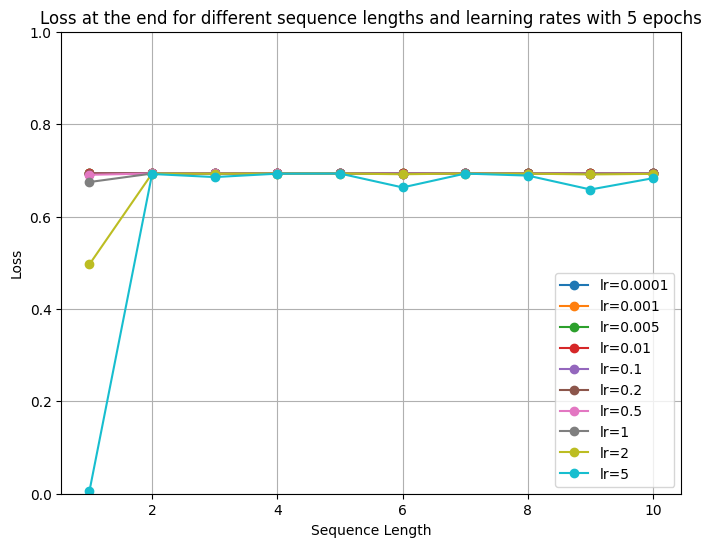

In [23]:
D, I, K = 1, 32, 1
epochs = 5
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.5, 1, 2, 5]
max_sequence_length = 10

performance_data = {lr: [] for lr in learning_rates}
sequence_lengths = range(1, max_sequence_length + 1)

for seq_len in sequence_lengths:
    for lr in learning_rates:
        model = FullyRecurrentNetwork(D, I, K)
        losses = model.train(lr, epochs, seq_len)
        loss = losses[-1]
        
        performance_data[lr].append(loss)

visualize_results(sequence_lengths, performance_data, epochs)

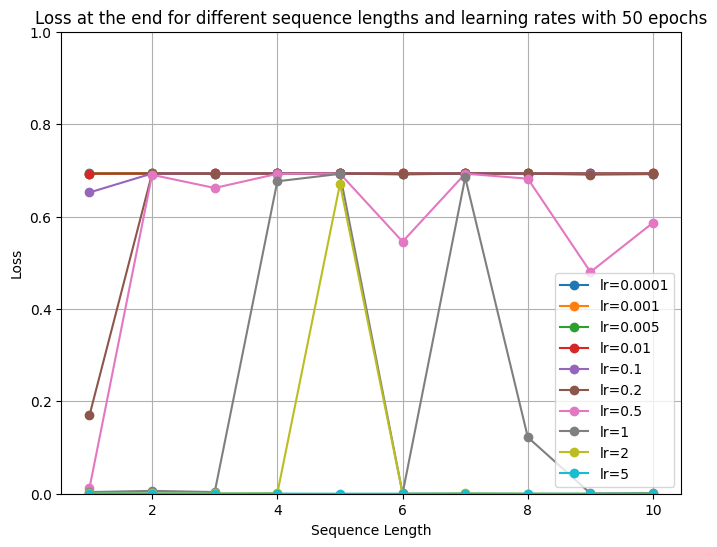

In [24]:
epochs = 50

performance_data = {lr: [] for lr in learning_rates}
sequence_lengths = range(1, max_sequence_length + 1)

for seq_len in sequence_lengths:
    for lr in learning_rates:
        model = FullyRecurrentNetwork(D, I, K)
        losses = model.train(lr, epochs, seq_len)
        loss = losses[-1]
        
        performance_data[lr].append(loss)

visualize_results(sequence_lengths, performance_data, epochs)

## Exercise 7: The Vanishing Gradient Problem

Analyze why the network is incapable of learning long-term dependencies. Show that $\|\frac{\partial a(T)}{\partial a(1)}\|_2 \leq \|R\|_2^{T-1}$ , where $\|\cdot\|_2$ is the spectral norm, and discuss how that affects the propagation of error signals through the time dimension of the network. 

*Hint: Use the fact that the spectral norm is submultiplicative for square matrices, i.e. $\|AB\|_2 \leq \|A\|_2\|B\|_2$ if $A$ and $B$ are both square.*

In order to show that
\begin{equation*}
	\left\lVert \frac{\partial a(T)}{\partial a(1)}\right\rVert_2 \leq 	
	\left\lVert R\right\rVert_2^{T-1}
\end{equation*}
We only calculate the norm of $\frac{\partial a(T)}{\partial a(T-1)}$ since 

\begin{equation*}
	\frac{\partial a(T)}{\partial a(1)} = \frac{\partial a(T)}{\partial a(T-1)} 
	\cdot \frac{\partial a(T-1)}{\partial a(T-2)} \cdots \frac{\partial 
	a(2)}{\partial a(1)}.
\end{equation*}


So let's calculate $\frac{\partial a(T)}{\partial a(T-1)}$. 

We know that $a(T)=f(W^\top 
x(T)+R^\top a(T-1))$ and therefore get
\begin{align*}
	\frac{\partial a(T)}{\partial a(T-1)} &= \frac{\partial f(W^\top 
	x(T)+R^\top a(T-1))}{\partial a(T-1)} \\
	&= \frac{\partial f(W^\top 
		x(T)+R^\top a(T-1))}{\partial a(T-1)}\frac{\partial W^\top 
		x(T)+R^\top a(T-1)}{\partial a(T-1)} \\
	&= \frac{\partial f(W^\top 
		x(T)+R^\top a(T-1))}{\partial a(T-1)} \cdot R^\top\\
	&= \operatorname{diag}(f')\cdot R^\top.
\end{align*} 
Taking now the spectral norm and using the fact that the spectral norm is 
submultiplicative, we get
\begin{equation*}
	\left\lVert \frac{\partial a(T)}{\partial a(T-1)}\right\rVert_2 = 
	\left\lVert \operatorname{diag}(f')\cdot R^\top \right\rVert_2 \leq 
	\left\lVert \operatorname{diag}(f')\right\rVert_2\cdot \left\lVert R^\top 
	\right\rVert_2 \leq \left\lVert R\right\rVert_2.
\end{equation*}
This holds as the spectral norm of $\operatorname{diag}(f')$ is less or equal 
than $1$, as we have $f(t)=\tanh(t)$, i.e. $f'(x)=1-\tanh^2(x)$ which is 
bounded by $1$ for $\tanh(x)=0$ which is the case for $x=0$.

Doing this now $T-1$ times, until we end up in $a(1)$, we obtain the desired 
bound.